In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import time

In [2]:
df = pd.read_csv('df_for_model.csv')
df = df.drop('Unnamed: 0',axis=1)

In [3]:
SiteEnergyUse_discrete = pd.qcut(df['SiteEnergyUse(kBtu)'],3, labels = False)
GHGEmission_discrete = pd.qcut(df['GHGEmissions(MetricTonsCO2e)'],3, labels = False)
df.insert(11, 'SiteEnergyUse_discrete', SiteEnergyUse_discrete)
df.insert(12, 'GHGEmission_discrete', GHGEmission_discrete)

In [4]:
df['SiteEnergyUse(kBtu)_log'] = np.log1p(df['SiteEnergyUse(kBtu)'])
df['GHGEmissions(MetricTonsCO2e)_log'] = np.log1p(df['GHGEmissions(MetricTonsCO2e)'])

In [5]:
df.columns

Index(['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SiteEnergyUse_discrete', 'GHGEmission_discrete',
       'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'MedianEnergyUse', 'MedianGHGEmission', 'NumberofUseTypes',
       'Laboratory', 'Wholesale Club/Supercenter', 'Residential Care Facility',
       'Refrigerated Warehouse', 'Other/Specialty Hospital',
       'Other - Technology/Science', 'Other - Mall', 'Convention Center',
       'Strip Mall', 'Vocational School', 'Police Station', 'Hotel',
       'Food Service', 'SPS-District K-12', 'Supermarket/Grocery Store',
       'Data Center', 'Urgent Care/Clinic/Other Outpatient', 'Library',
       'Automobile Dealership', 'Senior C

In [226]:
df=df.drop(df[df['PrimaryPropertyType']=='Hospital'].index)

In [7]:
data=df['Neighborhood'].values.reshape(-1,1)
enc = preprocessing.OneHotEncoder()
neighborhood_enc = enc.fit_transform(data).toarray()
neighborhood_enc.shape

(1800, 13)

In [8]:
data=df['PrimaryPropertyType'].values.reshape(-1,1)
enc = preprocessing.OneHotEncoder()
PropertyType_enc = enc.fit_transform(data).toarray()
PropertyType_enc.shape

(1800, 24)

In [9]:
X_cat = np.concatenate((neighborhood_enc,PropertyType_enc),axis=1)
X_cat.shape

(1800, 37)

In [10]:
# X_cat = np.concatenate((neighborhood_enc,df[['Laboratory', 'Wholesale Club/Supercenter', 'Residential Care Facility',
#        'Refrigerated Warehouse', 'Other/Specialty Hospital',
#        'Other - Technology/Science', 'Other - Mall', 'Convention Center',
#        'Strip Mall', 'Vocational School', 'Police Station', 'Hotel',
#        'Food Service', 'SPS-District K-12', 'Supermarket/Grocery Store',
#        'Data Center', 'Urgent Care/Clinic/Other Outpatient', 'Library',
#        'Automobile Dealership', 'Senior Care Community',
#        'Other - Restaurant/Bar', 'Convenience Store without Gas Station',
#        'Parking', 'Hospital (General Medical & Surgical)',
#        'Prison/Incarceration', 'Worship Facility', 'Medical Office', 'Other',
#        'Bar/Nightclub', 'Other - Education', 'Self-Storage Facility',
#        'Other - Public Services', 'Movie Theater', 'Swimming Pool',
#        'Repair Services (Vehicle; Shoe; Locksmith; etc)', 'Single Family Home',
#        'Personal Services (Health/Beauty; Dry Cleaning; etc)',
#        'Energy/Power Station', 'Residence Hall/Dormitory',
#        'Other - Recreation', 'Social/Meeting Hall',
#        'Small- and Mid-Sized Office', 'Courthouse', 'Distribution Center',
#        'Other - Services', 'Museum', 'Retail Store', 'Office',
#        'College/University', 'Hospital', 'Fitness Center/Health Club/Gym',
#        'Fast Food Restaurant', 'Multifamily Housing', 'Lifestyle Center',
#        'Fire Station', 'Manufacturing/Industrial Plant', 'K-12 School',
#        'Other - Entertainment/Public Assembly', 'Bank Branch', 'Food Sales',
#        'Adult Education', 'Large Office', 'Non-Refrigerated Warehouse',
#        'Outpatient Rehabilitation/Physical Therapy', 'Mixed Use Property',
#        'Restaurant', 'Other - Lodging/Residential', 'Pre-school/Daycare',
#        'Enclosed Mall', 'Performing Arts', 'Other - Utility',
#        'Financial Office']].to_numpy()),axis=1)

In [11]:
X_quant = df[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','MedianEnergyUse','MedianGHGEmission','NumberofUseTypes']]
X_quant.values.shape

(1800, 10)

In [12]:
X_cat.shape

(1800, 37)

In [13]:
Y_energy_log = df['SiteEnergyUse(kBtu)_log']
Y_ghg_log = df['GHGEmissions(MetricTonsCO2e)_log']
Y_energy_bis = df['SiteEnergyUse(kBtu)']
Y_ghg_bis = df['GHGEmissions(MetricTonsCO2e)']

In [14]:
X_cat_train, X_cat_test, X_quant_train, X_quant_test, Y_energy_log_train, Y_energy_log_test, Y_ghg_log_train, Y_ghg_log_test, Y_energy_bis_train, Y_energy_bis_test, Y_ghg_bis_train, Y_ghg_bis_test = train_test_split(X_cat, X_quant, Y_energy_log, Y_ghg_log, Y_energy_bis, Y_ghg_bis, test_size=0.3, stratify = df['PrimaryPropertyType'], random_state = 1)

In [15]:
std = preprocessing.StandardScaler()
X_quant_train_scaled = std.fit_transform(X_quant_train)
X_quant_test_scaled = std.transform(X_quant_test)

In [16]:
X_train = np.concatenate((X_cat_train,X_quant_train_scaled),axis=1)
X_test = np.concatenate((X_cat_test,X_quant_test_scaled),axis=1)

In [17]:
# Régression linéaire sur cibles en log
lr_energy = linear_model.LinearRegression()
lr_energy.fit(X_train,Y_energy_log_train)

print('R² test sur variable log:', round(metrics.r2_score(Y_energy_log_test,lr_energy.predict(X_test)),3))
print('R² test sur variable origine:', round(metrics.r2_score(np.expm1(Y_energy_log_test),np.expm1(lr_energy.predict(X_test))),3))

print('R² train sur variable log:',round(metrics.r2_score(Y_energy_log_train,lr_energy.predict(X_train)),3))
print('R² train sur variable orig:',round(metrics.r2_score(np.expm1(Y_energy_log_train),np.expm1(lr_energy.predict(X_train))),3))

R² test sur variable log: 0.471
R² test sur variable origine: -0.41
R² train sur variable log: 0.543
R² train sur variable orig: -25.96


In [18]:
# Régression linéaire sur cibles non transformées
lr_energy_bis = linear_model.LinearRegression()
lr_energy_bis.fit(X_train,Y_energy_bis_train)

print('R² test :', round(metrics.r2_score(Y_energy_bis_test,lr_energy_bis.predict(X_test)),3))
print('R² train :',round(metrics.r2_score(Y_energy_bis_train,lr_energy_bis.predict(X_train)),3))

R² test : 0.426
R² train : 0.803


In [19]:
recap_energy = pd.DataFrame(columns = ['R²','RMSE','Prediction time','Best parameters']).rename_axis('Model for energy')
recap_ghg = pd.DataFrame(columns = ['R²','RMSE','Prediction time','Best parameters']).rename_axis('Model for GHG')

In [20]:
recap_energy_log = pd.DataFrame(columns = ['R²','RMSE','Prediction time','Best parameters']).rename_axis('Model for energy log')
recap_ghg_log = pd.DataFrame(columns = ['R²','RMSE','Prediction time','Best parameters']).rename_axis('Model for GHG log')

In [21]:
def perf(X_train,Y_train,X_test,Y_test,model,hyperparam):
    
    '''Fonction permettant la recherche des meilleurs hyperparamètres d'un modèle puis 
    l'entrainement de ce modèle avec ces meilleurs paramètres sur le jeu X_train, Y_train
    La fonction retourne les performances du modèle (R², RMSE, temps d'éxécution) et les meilleurs paramètres
    
    le paramètre 'hyperparam' de la fonction est un dictionnaire
    
    Liste des hyperparamètres selon certains modèles :
    - Régression linéaire : pas d'hyperparamètre
    - Régression Ridge : alpha
    - Regression Lasso : alpha
    - Elasticnet : alpha et l1_ratio
    - SVR : estimator__C, estimator__epsilon et estimator__kernel
    - Random Forest : 
    '''
        
    model_gs = GridSearchCV(estimator = model, param_grid=hyperparam, cv=5)      
        
    model_gs.fit(X_train, Y_train)
    start_time = time.time()
    score = round(metrics.r2_score(Y_test,model_gs.predict(X_test)),5)     
    RMSE = round(metrics.mean_squared_error(Y_test,model_gs.predict(X_test), squared = False),5)
    pred_time = round(time.time()-start_time, 6)
    best_param = model_gs.best_params_
    for k, v in best_param.items():
        if type(v)!= str :
            best_param[k] = round(v, 6)
   
    return score, RMSE, pred_time, best_param



def recap_table(X_train,Y_energy_train,Y_ghg_train,X_test,Y_energy_test,Y_ghg_test,model,hyperparam):
    score, RMSE, pred_time, best_param = perf(X_train,Y_energy_train,X_test,Y_energy_test,model,hyperparam)
    recap_energy.loc[str(model),:] = [score,RMSE,pred_time,best_param]
    
    score, RMSE, pred_time, best_param = perf(X_train,Y_ghg_train,X_test,Y_ghg_test,model,hyperparam)
    recap_ghg.loc[str(model),:] = [score,RMSE,pred_time,best_param]

In [22]:
def perf_log(X_train,Y_train,X_test,Y_test,model,hyperparam):
    
    '''Fonction permettant la recherche des meilleurs hyperparamètres d'un modèle puis 
    l'entrainement de ce modèle avec ces meilleurs paramètres sur le jeu X_train, Y_train
    La fonction retourne les performances du modèle (R², RMSE, temps d'éxécution) et les meilleurs paramètres
    
    le paramètre 'hyperparam' de la fonction est un dictionnaire
    
    Liste des hyperparamètres selon certains modèles :
    - Régression linéaire : pas d'hyperparamètre
    - Régression Ridge : alpha
    - Regression Lasso : alpha
    - Elasticnet : alpha et l1_ratio
    - SVR : estimator__C, estimator__epsilon et estimator__kernel
    - Random Forest : 
    '''
        
    model_gs = GridSearchCV(estimator = model, param_grid=hyperparam, cv=5)      
        
    model_gs.fit(X_train, Y_train)
    start_time = time.time()
    score = round(metrics.r2_score(np.expm1(Y_test),np.expm1(model_gs.predict(X_test))),5)     
    RMSE = round(metrics.mean_squared_error(np.expm1(Y_test),np.expm1(model_gs.predict(X_test)), squared = False),5)
    pred_time = round(time.time()-start_time, 6)
    best_param = model_gs.best_params_
    for k, v in best_param.items():
        if type(v)!= str :
            best_param[k] = round(v, 6)
   
    return score,RMSE, pred_time, best_param



def recap_table_log(X_train,Y_energy_train,Y_ghg_train,X_test,Y_energy_test,Y_ghg_test,model,hyperparam):
    score, RMSE, pred_time, best_param = perf_log(X_train,Y_energy_train,X_test,Y_energy_test,model,hyperparam)
    recap_energy_log.loc[str(model),:] = [score,RMSE,pred_time,best_param]
    
    score, RMSE, pred_time, best_param = perf_log(X_train,Y_ghg_train,X_test,Y_ghg_test,model,hyperparam)
    recap_ghg_log.loc[str(model),:] = [score,RMSE,pred_time,best_param]

In [23]:
LinearReg = linear_model.LinearRegression();
recap_table(X_train,Y_energy_bis_train,Y_ghg_bis_train,X_test,Y_energy_bis_test,Y_ghg_bis_test,LinearReg,{})

In [24]:
ridge = Ridge();
recap_table(X_train,Y_energy_bis_train,Y_ghg_bis_train,X_test,Y_energy_bis_test,Y_ghg_bis_test,ridge,{'alpha': np.logspace(-4,2,100)})

In [25]:
lasso = Lasso();
recap_table(X_train,Y_energy_bis_train,Y_ghg_bis_train,X_test,Y_energy_bis_test,Y_ghg_bis_test,lasso,{'alpha': np.logspace(-4,2,100)})

C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.417937691656911e+16, tolerance: 96520725261772.31
  model = cd_fast.enet_coordinate_descent(
C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1360572169979813e+17, tolerance: 117614868306021.38
  model = cd_fast.enet_coordinate_descent(
C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1048175954458346e+17, tolerance: 118656246327521.9
  model = cd_fast.enet_coordinate_descent(
C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py

In [26]:
svr = SVR(kernel = 'linear');
recap_table(X_train,Y_energy_bis_train,Y_ghg_bis_train,X_test,Y_energy_bis_test,Y_ghg_bis_test,svr,{'C' : range(1,5),
                                       'epsilon' : np.linspace(0.1,1,10)})

In [27]:
svr = SVR();
recap_table(X_train,Y_energy_bis_train,Y_ghg_bis_train,X_test,Y_energy_bis_test,Y_ghg_bis_test,svr,{'C' : range(1,5),
                                        'epsilon' : np.linspace(0.1,1,10), 
                                       'kernel' : ['rbf','poly','sigmoid']})

In [28]:
rfr = RandomForestRegressor();
recap_table(X_train,Y_energy_bis_train,Y_ghg_bis_train,X_test,Y_energy_bis_test,Y_ghg_bis_test, rfr, {'min_samples_split' : [2, 5, 10], 
                                             'min_samples_leaf' : [1, 2, 4], 
                                             'max_depth': range(5,16,1)})

In [29]:
gb = LGBMRegressor();
recap_table(X_train,Y_energy_bis_train,Y_ghg_bis_train,X_test,Y_energy_bis_test,Y_ghg_bis_test, gb, {'n_estimators': [150],'max_depth':range(2,16), 
                                                                                                     'learning_rate' : [0.0001,0.001,0.01,0.1], 
                                                                                                     'boosting_type' : ['gbdt','goss', 'dart']})

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [30]:
recap_energy

,R²,RMSE,Prediction time,Best parameters
Model for energy,,,,
LinearRegression(),0.42557,9.12587e+06,0.003004,{}
Ridge(),0.51398,8.39426e+06,0.002,{'alpha': 21.544347}
Lasso(),0.42489,9.13122e+06,0.002003,{'alpha': 100.0}
SVR(kernel='linear'),-0.11367,1.27067e+07,0.078012,"{'C': 4, 'epsilon': 0.1}"
SVR(),-0.11402,1.27087e+07,0.075009,"{'C': 4, 'epsilon': 0.1, 'kernel': 'poly'}"
RandomForestRegressor(),0.70686,6.51913e+06,0.036003,"{'max_depth': 13, 'min_samples_leaf': 2, 'min_..."
LGBMRegressor(),0.61923,7.43e+06,0.014999,"{'boosting_type': 'goss', 'learning_rate': 0.0..."


In [31]:
recap_ghg

,R²,RMSE,Prediction time,Best parameters
Model for GHG,,,,
LinearRegression(),-0.042,346.247,0.002,{}
Ridge(),0.13663,315.174,0.002,{'alpha': 100.0}
Lasso(),0.11093,319.83,0.001,{'alpha': 7.054802}
SVR(kernel='linear'),0.24411,294.904,0.077006,"{'C': 4, 'epsilon': 0.1}"
SVR(),0.06294,328.349,0.113011,"{'C': 4, 'epsilon': 0.1, 'kernel': 'sigmoid'}"
RandomForestRegressor(),0.52177,234.569,0.039003,"{'max_depth': 11, 'min_samples_leaf': 2, 'min_..."
LGBMRegressor(),0.46867,247.248,0.012,"{'boosting_type': 'goss', 'learning_rate': 0.0..."


In [32]:
LinearReg = linear_model.LinearRegression();
recap_table_log(X_train,Y_energy_log_train,Y_ghg_log_train,X_test,Y_energy_log_test,Y_ghg_log_test,LinearReg,{})

In [33]:
ridge = Ridge();
recap_table_log(X_train,Y_energy_log_train,Y_ghg_log_train,X_test,Y_energy_log_test,Y_ghg_log_test,ridge,{'alpha': np.logspace(-4,2,100)})

In [34]:
lasso = Lasso();
recap_table_log(X_train,Y_energy_log_train,Y_ghg_log_train,X_test,Y_energy_log_test,Y_ghg_log_test,lasso,{'alpha': np.logspace(-4,2,100)})

C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.935034334533043, tolerance: 0.1824427546098573
  model = cd_fast.enet_coordinate_descent(
C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.240771630111908, tolerance: 0.18273387622930856
  model = cd_fast.enet_coordinate_descent(
C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.932044972970743, tolerance: 0.1854345888716325
  model = cd_fast.enet_coordinate_descent(
C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

In [35]:
svr = SVR(kernel = 'linear');
recap_table_log(X_train,Y_energy_log_train,Y_ghg_log_train,X_test,Y_energy_log_test,Y_ghg_log_test,svr,{'C' : range(1,5),
                                       'epsilon' : np.linspace(0.1,1,10)})

In [36]:
svr = SVR();
recap_table_log(X_train,Y_energy_log_train,Y_ghg_log_train,X_test,Y_energy_log_test,Y_ghg_log_test,svr,{'C' : range(1,5),
                                        'epsilon' : np.linspace(0.1,1,10), 
                                       'kernel' : ['rbf','poly','sigmoid']})

In [37]:
rfr = RandomForestRegressor();
recap_table_log(X_train,Y_energy_log_train,Y_ghg_log_train,X_test,Y_energy_log_test,Y_ghg_log_test, rfr, {'min_samples_split' : [2, 5, 10], 
                                             'min_samples_leaf' : [1, 2, 4], 
                                             'max_depth': range(5,16,1)})

In [181]:
gb = LGBMRegressor();
recap_table_log(X_train,Y_energy_log_train,Y_ghg_log_train,X_test,Y_energy_log_test,Y_ghg_log_test, gb, {'n_estimators': [2200],'max_depth':[4], 
                                                                                                     'learning_rate' : [0.01], 'random_state': [0],
                                                                                                     'boosting_type' : ['gbdt']})

In [182]:
recap_energy_log

,R²,RMSE,Prediction time,Best parameters
Model for energy log,,,,
LinearRegression(),-0.4103,1.42992e+07,0.003004,{}
Ridge(),-0.11385,1.27077e+07,0.001997,{'alpha': 100.0}
Lasso(),0.16385,1.10103e+07,0.002002,{'alpha': 0.162975}
SVR(kernel='linear'),-0.70141,1.57058e+07,0.032543,"{'C': 2, 'epsilon': 0.7}"
SVR(),0.49066,8.5933e+06,0.090007,"{'C': 4, 'epsilon': 0.1, 'kernel': 'rbf'}"
RandomForestRegressor(),0.62439,7.37948e+06,0.077007,"{'max_depth': 15, 'min_samples_leaf': 1, 'min_..."
LGBMRegressor(),0.72441,6.32107e+06,0.094009,"{'boosting_type': 'gbdt', 'learning_rate': 0.0..."


In [171]:
recap_ghg_log

,R²,RMSE,Prediction time,Best parameters
Model for GHG log,,,,
LinearRegression(),-0.01589,341.882,0.003001,{}
Ridge(),0.01615,336.448,0.003001,{'alpha': 100.0}
Lasso(),0.04314,331.799,0.002002,{'alpha': 0.187382}
SVR(kernel='linear'),-0.02982,344.217,0.030507,"{'C': 1, 'epsilon': 0.9}"
SVR(),0.20607,302.234,0.057003,"{'C': 3, 'epsilon': 0.6, 'kernel': 'rbf'}"
RandomForestRegressor(),0.3816,266.739,0.043004,"{'max_depth': 12, 'min_samples_leaf': 2, 'min_..."
LGBMRegressor(),0.57564,220.964,1.4547,"{'boosting_type': 'gbdt', 'learning_rate': 0.0..."


In [184]:
recap_energy_log.iloc[-1,-1]

{'boosting_type': 'gbdt',
 'learning_rate': 0.01,
 'max_depth': 4,
 'n_estimators': 2200,
 'random_state': 0}

In [183]:
recap_ghg_log.iloc[-1,-1]

{'boosting_type': 'gbdt',
 'learning_rate': 0.01,
 'max_depth': 4,
 'n_estimators': 2200,
 'random_state': 0}

In [207]:
gb_energy = LGBMRegressor(n_estimators = 2200, max_depth = 4, learning_rate = 0.01,random_state= 0, boosting_type = 'gbdt');
gb_energy.fit(X_train,Y_energy_log_train)
round(metrics.r2_score(np.expm1(Y_energy_log_test),np.expm1(gb_energy.predict(X_test))),5)

0.72441

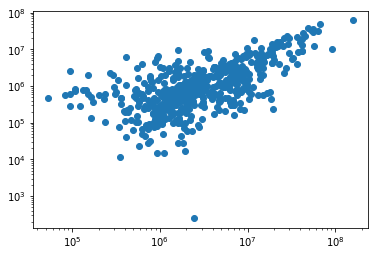

In [254]:
X = np.expm1(Y_energy_log_test)
Y = abs(np.expm1(Y_energy_log_test) - np.expm1(gb_energy.predict(X_test)))
import matplotlib.pyplot as plt
plt.xscale("log")
plt.yscale("log")
plt.scatter(X,Y);

In [258]:
gb_energy.feature_importances_

array([  30,   34,   49,  152,  129,  285,   87,  148,  124,  130,   52,
         65,   55,    0,  156,   10,   85,    0,  232,   48,  201,   40,
          0,  298,    0,    0,    0,    0,   50,    0,  292,    0,  205,
         20,    0,   27,   69, 3352,    0,  662, 3051,  470, 3174, 1409,
        983, 1214,  608])

In [212]:
gb_ghg = LGBMRegressor(n_estimators = 22500, max_depth = 3, learning_rate = 0.01,random_state= 0, boosting_type = 'gbdt');
gb_ghg.fit(X_train,Y_ghg_log_train)
round(metrics.r2_score(np.expm1(Y_ghg_log_test),np.expm1(gb_ghg.predict(X_test))),5)

0.57564

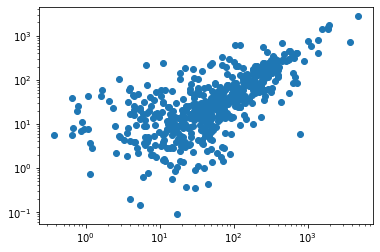

In [255]:
X = np.expm1(Y_ghg_log_test)
Y = abs(np.expm1(Y_ghg_log_test) - np.expm1(gb_ghg.predict(X_test)))
import matplotlib.pyplot as plt
plt.xscale("log")
plt.yscale("log")
plt.scatter(X,Y);

In [229]:
type_train, type_test= train_test_split(df['PrimaryPropertyType'], test_size=0.3, stratify = df['PrimaryPropertyType'], random_state = 1)

In [264]:
Y_energy = abs(np.expm1(Y_energy_log_test) - np.expm1(gb_energy.predict(X_test)))
data_energy = pd.DataFrame(data = {'Type': type_test, 'abs error' : Y_energy, 'relative error': Y/np.expm1(Y_energy_log_test)})
data_energy = data_energy.groupby(by='Type').median()

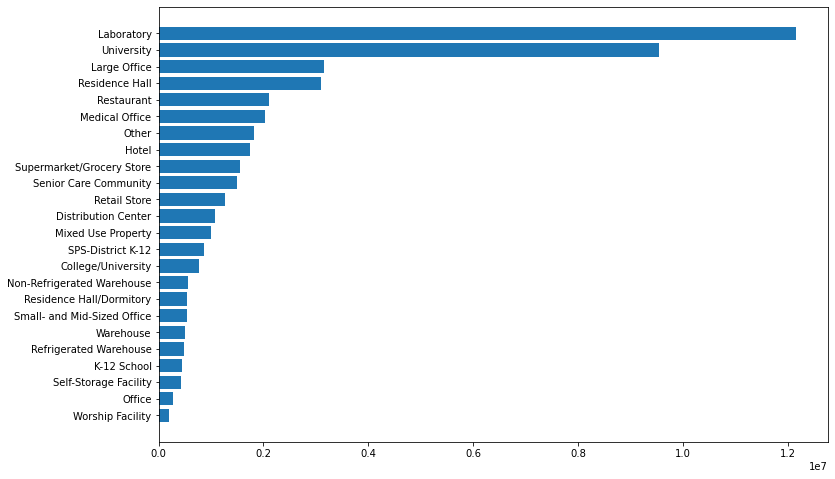

In [265]:
data1 = data_energy.sort_values(by='abs error')
plt.figure(figsize=(12,8))
plt.barh(data1.index , data1['abs error']);

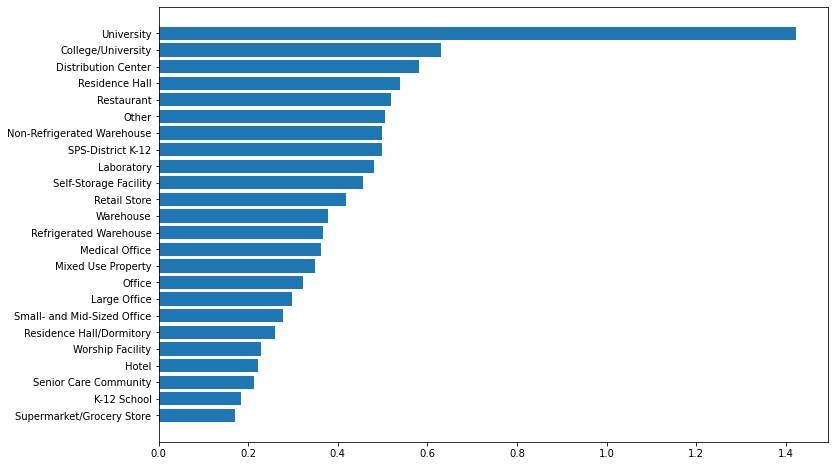

In [266]:
data2 = data_energy.sort_values(by='relative error')
plt.figure(figsize=(12,8))
plt.barh(data2.index , data2['relative error']);

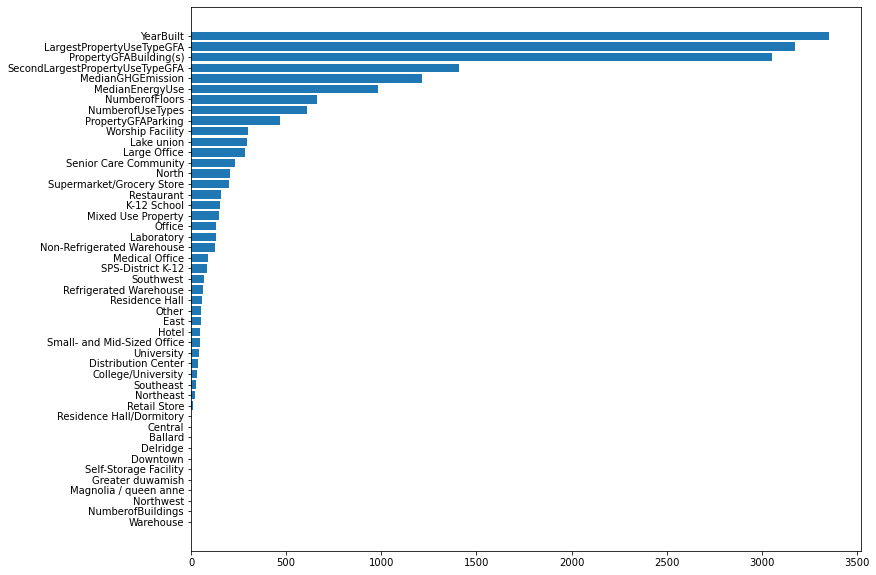

In [293]:
names = sorted(df['PrimaryPropertyType'].unique())+sorted(df['Neighborhood'].unique())+X_quant.columns.tolist()
data = pd.DataFrame(data = {'Names' : names, 'Importance':gb_energy.feature_importances_}).sort_values(by='Importance')
plt.figure(figsize=(12,10))
plt.barh(data['Names'] ,data['Importance']);